In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('/content/diabetes.csv')

Feature Engineering

In [12]:
df['BMI_Age_Ratio'] = df['BMI'] / (df['Age'] + 1)
df['Age_Squared'] = df['Age'] ** 2
df['BMI_Squared'] = df['BMI'] ** 2
df['Glucose_BMI_Interaction'] = df['Glucose'] * df['BMI']
df['Age_Log'] = np.log1p(df['Age'])
df['Insulin_Log'] = np.log1p(df['Insulin'])

In [13]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(df.drop('Outcome', axis=1))
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_poly)

# Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42)

In [15]:
# Optimize SVM with RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

In [16]:
svm_model = SVC(probability=True)
random_search = RandomizedSearchCV(svm_model, param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_svm = random_search.best_estimator_

# Predictions
y_pred_svm = best_svm.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


SVM Accuracy: 0.8298969072164949
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        97
           1       0.81      0.86      0.83        97

    accuracy                           0.83       194
   macro avg       0.83      0.83      0.83       194
weighted avg       0.83      0.83      0.83       194



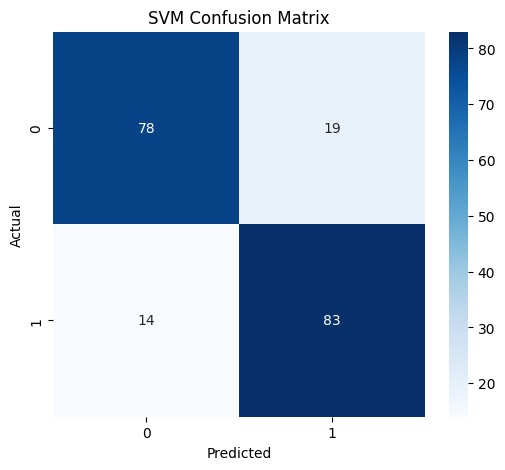

In [17]:
# Model Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
